<h1><center>Gesture Recognition</center></h1>
<center>By:</center>
<center>Peter Sharun Woodman M</center>
<center>Subramanian Srinivasan</center>
<center>Narasimha Reddy N L</center>

In [140]:
import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os

In [141]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)

In [142]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, LSTM, GlobalMaxPooling2D
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras.applications import mobilenet, inception_v3, mobilenetv2

# import regularizer
from keras.regularizers import l1, l2

# For plotting
import matplotlib.pyplot as plt

In [143]:
train_doc = np.random.permutation(open('../Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('../Project_data/val.csv').readlines())
batch_size = 20 #experiment with the batch size

In [144]:
def generator(source_path, folder_list, batch_size, image_shape = (128, 128)):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [4, 6, 8, 10, 11, 12, 13, 14, 16, 18, 19, 20, 21, 22, 24, 26] #creating a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list) // batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size, len(img_idx), image_shape[0], image_shape[1], 3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    # Crop the image
                    if (image.shape[0] == 360):
                        image = image[30:330, 30:330]
                    else:
                        image = image[15:110,10:150]
                    
                    # Resize the image                    
                    image = imresize(image, (image_shape[0], image_shape[1]))
                    
                    batch_data[folder,idx,:,:,0] = image[:,:,0] / 255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1] / 255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2] / 255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        rem_data_points = len(folder_list) % batch_size
        if (rem_data_points != 0):
            batch_data = np.zeros((rem_data_points, len(img_idx), image_shape[0], image_shape[1], 3)) 
            batch_labels = np.zeros((rem_data_points, 5)) 
            for folder in range(rem_data_points):
                imgs = os.listdir(source_path+'/'+ t[folder + (rem_data_points)].split(';')[0]) 
                for idx,item in enumerate(img_idx): 
                    image = imread(source_path+'/'+ t[folder + (rem_data_points)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    # Crop the image
                    if (image.shape[0] == 360):
                        image = image[30:330, 30:330]
                    else:
                        image = image[15:110,10:150]
                        
                    # Resize the image     
                    image = imresize(image, (image_shape[0], image_shape[1]))
                    
                    batch_data[folder,idx,:,:,0] = (image[:,:,0]) / 255  
                    batch_data[folder,idx,:,:,1] = (image[:,:,1]) / 255  
                    batch_data[folder,idx,:,:,2] = (image[:,:,2]) / 255  
                    
                batch_labels[folder, int(t[folder + (rem_data_points)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

In [145]:
curr_dt_time = datetime.datetime.now()
train_path = '../Project_data/train'
val_path = '../Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


In [146]:
def retTrainGenerator():
    train_generator = generator(train_path, train_doc, batch_size)
    return train_generator
    
def retValGenerator():
    val_generator = generator(val_path, val_doc, batch_size)
    return val_generator

In [147]:
def retCallbacksList(model_code):
    model_name = model_code + '_' + 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

    if not os.path.exists(model_name):
        os.mkdir(model_name)

    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)# write the REducelronplateau code here
    
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

    callbacks_list = [checkpoint, LR, es]
    
    return callbacks_list

In [148]:
def retStepsPerEpoch():
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1
    return steps_per_epoch

def retValidationSteps():
    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1
    return validation_steps

In [149]:
# Function to plot the loss and accurcay for training and validation data
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

In [150]:
# Set the frames per video and number of classes
framesPerVideo = 16
num_classes = 5

In [ ]:
# ---------------------------Start of Conv3D Models---------------------------

### Model 1 - Conv3D
#### Model Code: CONV3D_v1
#### Model Description:
    # Filter size = [3, 3, 3]
    # Pool size = [2, 2, 2]
    # CONV 3D Layers = 2
    # Dense Layers = 1 (256)
    # Dropouts = No
    # Regularizer = No
    # Trainable Parameters = ~29M

In [18]:
filtersize = [3, 3, 3]
image_shape = (128, 128)
input_shape = (framesPerVideo, image_shape[0], image_shape[1], 3)
pool_size = (2, 2, 2)

model = Sequential()
model.add(Conv3D(32, filtersize, input_shape=input_shape, activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling3D(pool_size=pool_size))

model.add(Conv3D(64, filtersize, activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling3D(pool_size=pool_size))

model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))

model.add(Dense(5, activation='softmax'))
optimiser = optimizers.Adam(lr=0.001)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
                  
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_3 (Conv3D)            (None, 14, 126, 126, 32)  2624      
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 7, 63, 63, 32)     0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 5, 61, 61, 64)     55360     
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 2, 30, 30, 64)     0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 115200)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               29491456  
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 1285      
Total para

In [19]:
history_CONV3D_v1 = model.fit_generator(retTrainGenerator(), steps_per_epoch=retStepsPerEpoch(), epochs=num_epochs, verbose=1, 
                    callbacks=retCallbacksList('CONV3D_v1'), validation_data=retValGenerator(), 
                    validation_steps=retValidationSteps(), class_weight=None, workers=1, initial_epoch=0)

Source path =  ../Project_data/val ; batch size = 20
Source path =  ../Project_data/train ; batch size = 20
Epoch 1/10


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  del sys.path[0]
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


32/34 [===========================>..] - ETA: 2s - loss: 12.9024 - categorical_accuracy: 0.1781

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


34/34 [==============================] - 44s 1s/step - loss: 12.6386 - categorical_accuracy: 0.1957 - val_loss: 13.5392 - val_categorical_accuracy: 0.1600
Epoch 2/10
34/34 [==============================] - 41s 1s/step - loss: 13.2005 - categorical_accuracy: 0.1810 - val_loss: 13.5392 - val_categorical_accuracy: 0.1600
Epoch 3/10
34/34 [==============================] - 41s 1s/step - loss: 13.0700 - categorical_accuracy: 0.1891 - val_loss: 13.5392 - val_categorical_accuracy: 0.1600
Epoch 4/10
34/34 [==============================] - 41s 1s/step - loss: 13.0700 - categorical_accuracy: 0.1891 - val_loss: 13.5392 - val_categorical_accuracy: 0.1600
Epoch 5/10
34/34 [==============================] - 41s 1s/step - loss: 13.0463 - categorical_accuracy: 0.1906 - val_loss: 13.5392 - val_categorical_accuracy: 0.1600
Epoch 6/10
34/34 [==============================] - 41s 1s/step - loss: 13.2005 - categorical_accuracy: 0.1810 - val_loss: 13.5392 - val_categorical_accuracy: 0.1600
Epoch 7/10
34/3

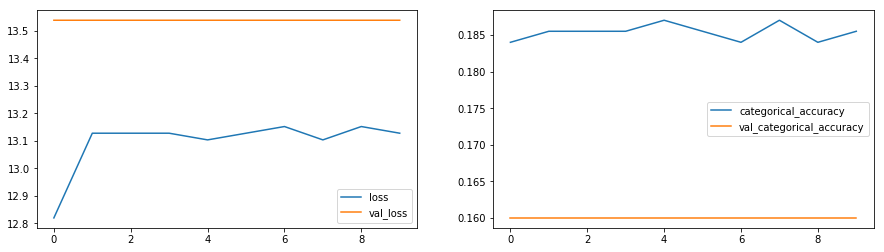

In [20]:
plot(history_CONV3D_v1)

### Model 2 - Conv3D
#### Model Code: CONV3D_v2
#### Model Description:
    # Filter size = [3, 3, 3]
    # Pool size = [2, 2, 2]
    # CONV 3D Layers = 2
    # Dense Layers = 1 (128)
    # Dropouts = Low
    # Regularizer = No
    # Trainable Parameters = ~14M

In [21]:
filtersize = [3, 3, 3]
image_shape = (128, 128)
input_shape = (framesPerVideo, image_shape[0], image_shape[1], 3)
pool_size = (2, 2, 2)

model = Sequential()
model.add(Conv3D(32, filtersize, input_shape=input_shape, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=pool_size))
model.add(Dropout(0.25))

model.add(Conv3D(64, filtersize, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=pool_size))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(5, activation='softmax'))
optimiser = optimizers.Adam(lr=0.001)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
                  
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_7 (Conv3D)            (None, 14, 126, 126, 32)  2624      
_________________________________________________________________
max_pooling3d_7 (MaxPooling3 (None, 7, 63, 63, 32)     0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 7, 63, 63, 32)     0         
_________________________________________________________________
conv3d_8 (Conv3D)            (None, 5, 61, 61, 64)     55360     
_________________________________________________________________
batch_normalization_3 (Batch (None, 5, 61, 61, 64)     256       
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 (None, 2, 30, 30, 64)     0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 2, 30, 30, 64)     0         
__________

In [22]:
history_CONV3D_v2 = model.fit_generator(retTrainGenerator(), steps_per_epoch=retStepsPerEpoch(), epochs=num_epochs, verbose=1, 
                    callbacks=retCallbacksList('CONV3D_v2'), validation_data=retValGenerator(), 
                    validation_steps=retValidationSteps(), class_weight=None, workers=1, initial_epoch=0)

Source path =  ../Project_data/valSource path =   ; batch size = 20
Epoch 1/10
../Project_data/train ; batch size = 20


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  del sys.path[0]
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


32/34 [===========================>..] - ETA: 2s - loss: 1.6295 - categorical_accuracy: 0.4328

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


34/34 [==============================] - 47s 1s/step - loss: 1.5783 - categorical_accuracy: 0.4540 - val_loss: 10.6679 - val_categorical_accuracy: 0.1800
Epoch 2/10
34/34 [==============================] - 44s 1s/step - loss: 0.8598 - categorical_accuracy: 0.6490 - val_loss: 8.5886 - val_categorical_accuracy: 0.2100
Epoch 3/10
34/34 [==============================] - 43s 1s/step - loss: 0.5798 - categorical_accuracy: 0.7770 - val_loss: 11.3225 - val_categorical_accuracy: 0.2800
Epoch 4/10
34/34 [==============================] - 44s 1s/step - loss: 0.4176 - categorical_accuracy: 0.8727 - val_loss: 11.4426 - val_categorical_accuracy: 0.2800
Epoch 5/10
34/34 [==============================] - 43s 1s/step - loss: 0.2504 - categorical_accuracy: 0.9279 - val_loss: 11.5779 - val_categorical_accuracy: 0.2800
Epoch 6/10
34/34 [==============================] - 43s 1s/step - loss: 0.1326 - categorical_accuracy: 0.9728 - val_loss: 12.2549 - val_categorical_accuracy: 0.2400
Epoch 7/10
34/34 [====

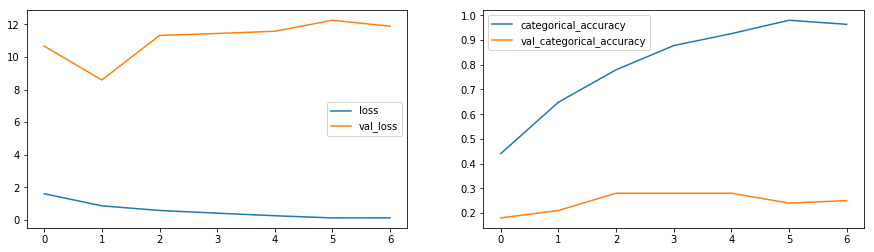

In [23]:
plot(history_CONV3D_v2)

### Model 3 - Conv 3D Model 3
#### Model Code: CONV3D_v3
#### Model Description:
    # Filter size = [3, 3, 3]
    # Pool size = [2, 2, 2]
    # CONV 3D Layers = 2
    # Dense Layers = 1 (64)
    # Dropouts = Medium
    # Regularizer = No
    # Trainable Parameters = ~7M

In [24]:
filtersize = [3, 3, 3]
image_shape = (128, 128)
input_shape = (framesPerVideo, image_shape[0], image_shape[1], 3)
pool_size = (2, 2, 2)

model = Sequential()
model.add(Conv3D(32, filtersize, input_shape=input_shape, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=pool_size))
model.add(Dropout(0.5))

model.add(Conv3D(64, filtersize, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=pool_size))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(5, activation='softmax'))
optimiser = optimizers.Adam(lr=0.001)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
                  
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_9 (Conv3D)            (None, 14, 126, 126, 32)  2624      
_________________________________________________________________
batch_normalization_5 (Batch (None, 14, 126, 126, 32)  128       
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 7, 63, 63, 32)     0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 7, 63, 63, 32)     0         
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 5, 61, 61, 64)     55360     
_________________________________________________________________
batch_normalization_6 (Batch (None, 5, 61, 61, 64)     256       
_________________________________________________________________
max_pooling3d_10 (MaxPooling (None, 2, 30, 30, 64)     0         
__________

In [25]:
history_CONV3D_v3 = model.fit_generator(retTrainGenerator(), steps_per_epoch=retStepsPerEpoch(), epochs=num_epochs, verbose=1, 
                    callbacks=retCallbacksList('CONV3D_v3'), validation_data=retValGenerator(), 
                    validation_steps=retValidationSteps(), class_weight=None, workers=1, initial_epoch=0)

Source path =  Source path =  ../Project_data/train ; batch size = 20
Epoch 1/10
../Project_data/val ; batch size = 20


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  del sys.path[0]
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


32/34 [===========================>..] - ETA: 2s - loss: 1.6407 - categorical_accuracy: 0.3641

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


34/34 [==============================] - 48s 1s/step - loss: 1.6024 - categorical_accuracy: 0.3753 - val_loss: 2.8799 - val_categorical_accuracy: 0.4200
Epoch 2/10
34/34 [==============================] - 43s 1s/step - loss: 1.0806 - categorical_accuracy: 0.5879 - val_loss: 3.0261 - val_categorical_accuracy: 0.3000
Epoch 3/10
34/34 [==============================] - 43s 1s/step - loss: 0.7735 - categorical_accuracy: 0.6990 - val_loss: 2.9663 - val_categorical_accuracy: 0.2800
Epoch 4/10
34/34 [==============================] - 44s 1s/step - loss: 0.6328 - categorical_accuracy: 0.7903 - val_loss: 2.2658 - val_categorical_accuracy: 0.3100
Epoch 5/10
34/34 [==============================] - 44s 1s/step - loss: 0.4490 - categorical_accuracy: 0.8617 - val_loss: 2.6600 - val_categorical_accuracy: 0.3000
Epoch 6/10
34/34 [==============================] - 45s 1s/step - loss: 0.3558 - categorical_accuracy: 0.9051 - val_loss: 2.2957 - val_categorical_accuracy: 0.3200
Epoch 7/10
34/34 [=========

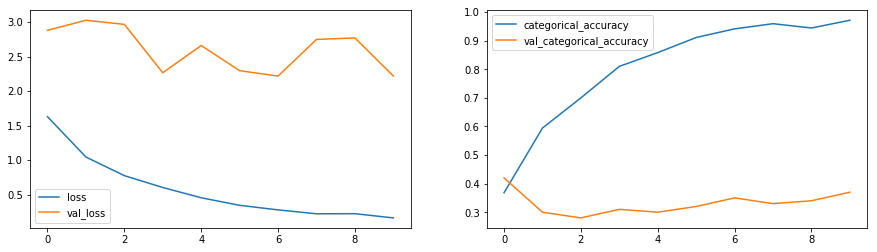

In [26]:
plot(history_CONV3D_v3)

### Model 4 - Conv3D
#### Model Code: CONV3D_v4
#### Model Description:
    # Filter size = [3, 3, 3]
    # Pool size = [2, 2, 2]
    # CONV 3D Layers = 2
    # Dense Layers = 1 (32)
    # Dropouts = High
    # Regularizer = No
    # Trainable Parameters = ~3M

In [27]:
filtersize = [3, 3, 3]
image_shape = (128, 128)
input_shape = (framesPerVideo, image_shape[0], image_shape[1], 3)
pool_size = (2, 2, 2)

model = Sequential()
model.add(Conv3D(32, filtersize, input_shape=input_shape, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=pool_size))
model.add(Dropout(0.7))

model.add(Conv3D(64, filtersize, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=pool_size))
model.add(Dropout(0.6))

model.add(Flatten())
model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(5, activation='softmax'))
optimiser = optimizers.Adam(lr=0.001)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
                  
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_11 (Conv3D)           (None, 14, 126, 126, 32)  2624      
_________________________________________________________________
batch_normalization_8 (Batch (None, 14, 126, 126, 32)  128       
_________________________________________________________________
max_pooling3d_11 (MaxPooling (None, 7, 63, 63, 32)     0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 7, 63, 63, 32)     0         
_________________________________________________________________
conv3d_12 (Conv3D)           (None, 5, 61, 61, 64)     55360     
_________________________________________________________________
batch_normalization_9 (Batch (None, 5, 61, 61, 64)     256       
_________________________________________________________________
max_pooling3d_12 (MaxPooling (None, 2, 30, 30, 64)     0         
__________

In [28]:
history_CONV3D_v4 = model.fit_generator(retTrainGenerator(), steps_per_epoch=retStepsPerEpoch(), epochs=num_epochs, verbose=1, 
                    callbacks=retCallbacksList('CONV3D_v4'), validation_data=retValGenerator(), 
                    validation_steps=retValidationSteps(), class_weight=None, workers=1, initial_epoch=0)

Source path =  ../Project_data/val ; batch size = 20
Source path =  ../Project_data/train ; batch size = 20
Epoch 1/10


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  del sys.path[0]
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


32/34 [===========================>..] - ETA: 2s - loss: 1.8802 - categorical_accuracy: 0.3000

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


34/34 [==============================] - 48s 1s/step - loss: 1.8645 - categorical_accuracy: 0.2943 - val_loss: 4.9866 - val_categorical_accuracy: 0.3600
Epoch 2/10
34/34 [==============================] - 44s 1s/step - loss: 1.4261 - categorical_accuracy: 0.4091 - val_loss: 3.7765 - val_categorical_accuracy: 0.3300
Epoch 3/10
34/34 [==============================] - 44s 1s/step - loss: 1.2205 - categorical_accuracy: 0.4930 - val_loss: 1.6850 - val_categorical_accuracy: 0.5000
Epoch 4/10
34/34 [==============================] - 44s 1s/step - loss: 1.1418 - categorical_accuracy: 0.5202 - val_loss: 1.4135 - val_categorical_accuracy: 0.5500
Epoch 5/10
34/34 [==============================] - 43s 1s/step - loss: 1.0619 - categorical_accuracy: 0.5784 - val_loss: 2.2912 - val_categorical_accuracy: 0.3400
Epoch 6/10
34/34 [==============================] - 43s 1s/step - loss: 0.9364 - categorical_accuracy: 0.6358 - val_loss: 2.2652 - val_categorical_accuracy: 0.3100
Epoch 7/10
34/34 [=========

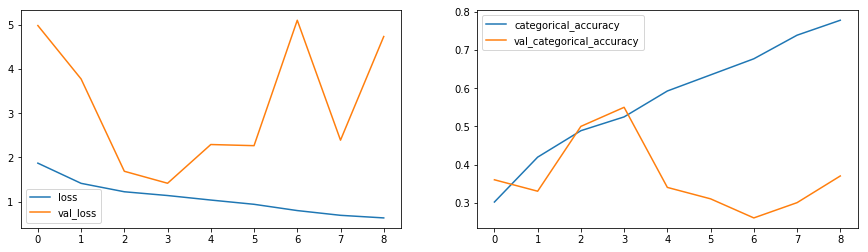

In [29]:
plot(history_CONV3D_v4)

### Model 5 - Conv3D
#### Model Code: CONV3D_v5
#### Model Description:
    # Filter size = [3, 3, 3]
    # Pool size = [2, 2, 2]
    # CONV 3D Layers = 2
    # Dense Layers = 1 (16)
    # Dropouts = Medium
    # Regularizer = No
    # Trainable Parameters = ~952K

In [30]:
filtersize = [3, 3, 3]
image_shape = (128, 128)
input_shape = (framesPerVideo, image_shape[0], image_shape[1], 3)
pool_size = (2, 2, 2)

model = Sequential()
model.add(Conv3D(32, filtersize, input_shape=input_shape, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=pool_size))
model.add(Dropout(0.5))

model.add(Conv3D(32, filtersize, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=pool_size))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(16, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(5, activation='softmax'))
optimiser = optimizers.Adam(lr=0.001)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
                  
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_13 (Conv3D)           (None, 14, 126, 126, 32)  2624      
_________________________________________________________________
batch_normalization_11 (Batc (None, 14, 126, 126, 32)  128       
_________________________________________________________________
max_pooling3d_13 (MaxPooling (None, 7, 63, 63, 32)     0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 7, 63, 63, 32)     0         
_________________________________________________________________
conv3d_14 (Conv3D)           (None, 5, 61, 61, 32)     27680     
_________________________________________________________________
batch_normalization_12 (Batc (None, 5, 61, 61, 32)     128       
_________________________________________________________________
max_pooling3d_14 (MaxPooling (None, 2, 30, 30, 32)     0         
__________

In [31]:
history_CONV3D_v5 = model.fit_generator(retTrainGenerator(), steps_per_epoch=retStepsPerEpoch(), epochs=num_epochs, verbose=1, 
                    callbacks=retCallbacksList('CONV3D_v5'), validation_data=retValGenerator(), 
                    validation_steps=retValidationSteps(), class_weight=None, workers=1, initial_epoch=0)

Source path =  ../Project_data/valSource path =  ../Project_data/train  ; batch size = 20Epoch 1/10
; batch size = 20



/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  del sys.path[0]
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


32/34 [===========================>..] - ETA: 2s - loss: 1.5814 - categorical_accuracy: 0.2875

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


34/34 [==============================] - 47s 1s/step - loss: 1.5511 - categorical_accuracy: 0.3113 - val_loss: 5.5397 - val_categorical_accuracy: 0.2300
Epoch 2/10
34/34 [==============================] - 42s 1s/step - loss: 1.3418 - categorical_accuracy: 0.3797 - val_loss: 2.9624 - val_categorical_accuracy: 0.2800
Epoch 3/10
34/34 [==============================] - 43s 1s/step - loss: 1.2452 - categorical_accuracy: 0.4525 - val_loss: 3.9515 - val_categorical_accuracy: 0.2900
Epoch 4/10
34/34 [==============================] - 43s 1s/step - loss: 1.1590 - categorical_accuracy: 0.4901 - val_loss: 1.2947 - val_categorical_accuracy: 0.4000
Epoch 5/10
34/34 [==============================] - 43s 1s/step - loss: 1.0317 - categorical_accuracy: 0.5651 - val_loss: 1.7245 - val_categorical_accuracy: 0.3900
Epoch 6/10
34/34 [==============================] - 42s 1s/step - loss: 0.9662 - categorical_accuracy: 0.6262 - val_loss: 2.4800 - val_categorical_accuracy: 0.3000
Epoch 7/10
34/34 [=========

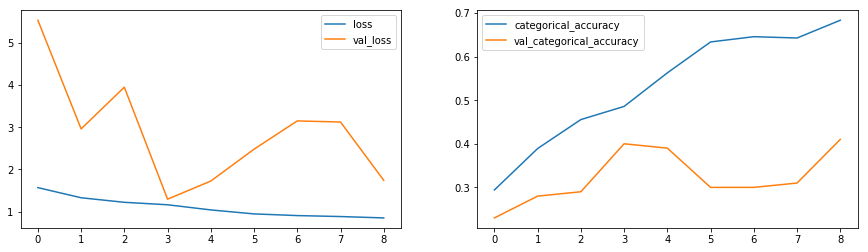

In [32]:
plot(history_CONV3D_v5)

### Model 6 - Conv3D
#### Model Code: CONV3D_v6
#### Model Description:
    # Filter size = [3, 3, 3]
    # Pool size = [3, 3, 3]
    # CONV 3D Layers = 2
    # Dense Layers = 1 (64)
    # Dropouts = Medium, remove for FC
    # Regularizer = No
    # Trainable Parameters = ~861K

In [24]:
filtersize = [3, 3, 3]
image_shape = (128, 128)
input_shape = (framesPerVideo, image_shape[0], image_shape[1], 3)
pool_size = (3, 3, 3)

model = Sequential()
model.add(Conv3D(32, filtersize, input_shape=input_shape, activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=pool_size))
model.add(Dropout(0.50))

model.add(Conv3D(64, filtersize, activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=pool_size))
model.add(Dropout(0.50))

model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())

model.add(Dense(5, activation='softmax'))
optimiser = optimizers.Adam(lr=0.001)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
                  
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_7 (Conv3D)            (None, 16, 128, 128, 32)  2624      
_________________________________________________________________
batch_normalization_10 (Batc (None, 16, 128, 128, 32)  128       
_________________________________________________________________
max_pooling3d_7 (MaxPooling3 (None, 5, 42, 42, 32)     0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 5, 42, 42, 32)     0         
_________________________________________________________________
conv3d_8 (Conv3D)            (None, 5, 42, 42, 64)     55360     
_________________________________________________________________
batch_normalization_11 (Batc (None, 5, 42, 42, 64)     256       
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 (None, 1, 14, 14, 64)     0         
__________

In [25]:
history_CONV3D_v6 = model.fit_generator(retTrainGenerator(), steps_per_epoch=retStepsPerEpoch(), epochs=num_epochs, verbose=1, 
                    callbacks=retCallbacksList('CONV3D_v6'), validation_data=retValGenerator(), 
                    validation_steps=retValidationSteps(), class_weight=None, workers=1, initial_epoch=0)

Source path =  ../Project_data/val ; batch size = 20
Source path =  ../Project_data/train ; batch size = 20
Epoch 1/10


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  del sys.path[0]
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


32/34 [===========================>..] - ETA: 2s - loss: 1.3692 - categorical_accuracy: 0.4500

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


34/34 [==============================] - 48s 1s/step - loss: 1.3761 - categorical_accuracy: 0.4481 - val_loss: 1.8203 - val_categorical_accuracy: 0.3500
Epoch 2/10
34/34 [==============================] - 43s 1s/step - loss: 0.8486 - categorical_accuracy: 0.6667 - val_loss: 1.9751 - val_categorical_accuracy: 0.3000
Epoch 3/10
34/34 [==============================] - 43s 1s/step - loss: 0.6554 - categorical_accuracy: 0.7550 - val_loss: 1.9480 - val_categorical_accuracy: 0.3900
Epoch 4/10
34/34 [==============================] - 43s 1s/step - loss: 0.6820 - categorical_accuracy: 0.7667 - val_loss: 1.9488 - val_categorical_accuracy: 0.4000
Epoch 5/10
34/34 [==============================] - 44s 1s/step - loss: 0.5404 - categorical_accuracy: 0.8197 - val_loss: 1.0344 - val_categorical_accuracy: 0.5800
Epoch 6/10
34/34 [==============================] - 43s 1s/step - loss: 0.4260 - categorical_accuracy: 0.8712 - val_loss: 1.2875 - val_categorical_accuracy: 0.5500
Epoch 7/10
34/34 [=========

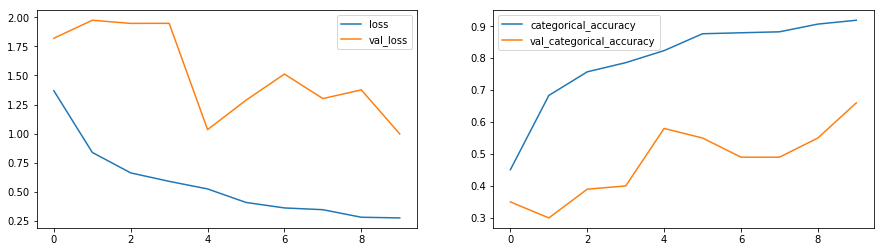

In [26]:
plot(history_CONV3D_v6)

### Model 7 - Conv3D
#### Model Code: CONV3D_v7
#### Model Description:
    # Filter size = [3, 3, 3]
    # Pool size = [3, 3, 3]
    # CONV 3D Layers = 2
    # Dense Layers = 1 (64)
    # Dropouts = Low, remove for FC
    # Regularizer = Yes, L2 regularizer
    # Trainable Parameters = ~861K

In [32]:
filtersize = [3, 3, 3]
image_shape = (128, 128)
input_shape = (framesPerVideo, image_shape[0], image_shape[1], 3)
pool_size = (3, 3, 3)

model = Sequential()
model.add(Conv3D(32, filtersize, input_shape=input_shape, activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=pool_size))
model.add(Dropout(0.15))

model.add(Conv3D(64, filtersize, activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=pool_size))
model.add(Dropout(0.15))

model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_initializer='he_uniform', activity_regularizer=l2(0.00001)))
model.add(BatchNormalization())

model.add(Dense(5, activation='softmax'))
optimiser = optimizers.Adam(lr=0.001)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_13 (Conv3D)           (None, 16, 128, 128, 32)  2624      
_________________________________________________________________
batch_normalization_19 (Batc (None, 16, 128, 128, 32)  128       
_________________________________________________________________
max_pooling3d_13 (MaxPooling (None, 5, 42, 42, 32)     0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 5, 42, 42, 32)     0         
_________________________________________________________________
conv3d_14 (Conv3D)           (None, 5, 42, 42, 64)     55360     
_________________________________________________________________
batch_normalization_20 (Batc (None, 5, 42, 42, 64)     256       
_________________________________________________________________
max_pooling3d_14 (MaxPooling (None, 1, 14, 14, 64)     0         
__________

In [33]:
history_CONV3D_v7 = model.fit_generator(retTrainGenerator(), steps_per_epoch=retStepsPerEpoch(), epochs=10, verbose=1, 
                    callbacks=retCallbacksList('CONV3D_v7'), validation_data=retValGenerator(), 
                    validation_steps=retValidationSteps(), class_weight=None, workers=1, initial_epoch=0)

Source path =  ../Project_data/val ; batch size = 20
Source path =  ../Project_data/train ; batch size = 20
Epoch 1/10


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  del sys.path[0]
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


32/34 [===========================>..] - ETA: 2s - loss: 1.5722 - categorical_accuracy: 0.4422

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


34/34 [==============================] - 46s 1s/step - loss: 1.5541 - categorical_accuracy: 0.4422 - val_loss: 1.3036 - val_categorical_accuracy: 0.5200
Epoch 2/10
34/34 [==============================] - 42s 1s/step - loss: 1.1430 - categorical_accuracy: 0.6667 - val_loss: 1.2201 - val_categorical_accuracy: 0.6100
Epoch 3/10
34/34 [==============================] - 42s 1s/step - loss: 1.0180 - categorical_accuracy: 0.7277 - val_loss: 1.1196 - val_categorical_accuracy: 0.6400
Epoch 4/10
34/34 [==============================] - 42s 1s/step - loss: 0.8381 - categorical_accuracy: 0.8182 - val_loss: 1.1107 - val_categorical_accuracy: 0.6300
Epoch 5/10
34/34 [==============================] - 42s 1s/step - loss: 0.8001 - categorical_accuracy: 0.8440 - val_loss: 1.2348 - val_categorical_accuracy: 0.5500
Epoch 6/10
34/34 [==============================] - 42s 1s/step - loss: 0.6934 - categorical_accuracy: 0.8675 - val_loss: 1.1149 - val_categorical_accuracy: 0.6400
Epoch 7/10
34/34 [=========

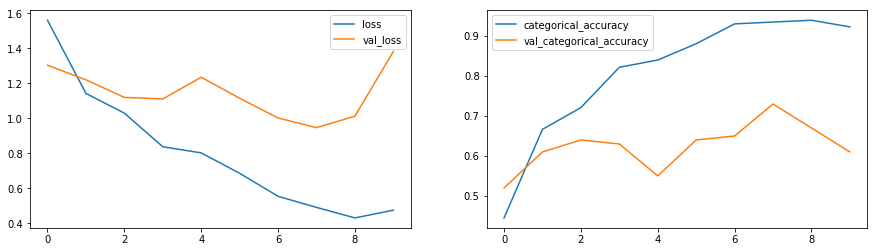

In [34]:
plot(history_CONV3D_v7)

### Model 8 - Conv3D
#### Model Code: CONV3D_v8
#### Model Description:
    # Filter size = [3, 3, 3]
    # Pool size = [3, 3, 3]
    # CONV 3D Layers = 2
    # Dense Layers = 1 (64)
    # Dropouts = Low, add for FC
    # Regularizer = Yes, L2 regularizer (for CONV3D too)
    # Trainable Parameters = ~861K

In [20]:
filtersize = [3, 3, 3]
image_shape = (128, 128)
input_shape = (framesPerVideo, image_shape[0], image_shape[1], 3)
pool_size = (3, 3, 3)

model = Sequential()
model.add(Conv3D(32, filtersize, input_shape=input_shape, activation='relu', kernel_initializer='he_uniform', 
                 padding='same', activity_regularizer=l2(0.00001)))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=pool_size))
model.add(Dropout(0.15))

model.add(Conv3D(64, filtersize, activation='relu', kernel_initializer='he_uniform', 
                 padding='same', activity_regularizer=l2(0.00001)))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=pool_size))
model.add(Dropout(0.15))

model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_initializer='he_uniform', activity_regularizer=l2(0.00001)))
model.add(BatchNormalization())
model.add(Dropout(0.15))

model.add(Dense(5, activation='softmax'))
optimiser = optimizers.Adam(lr=0.001)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_3 (Conv3D)            (None, 16, 128, 128, 32)  2624      
_________________________________________________________________
batch_normalization_6 (Batch (None, 16, 128, 128, 32)  128       
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 5, 42, 42, 32)     0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 5, 42, 42, 32)     0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 5, 42, 42, 64)     55360     
_________________________________________________________________
batch_normalization_7 (Batch (None, 5, 42, 42, 64)     256       
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 1, 14, 14, 64)     0         
__________

In [21]:
history_CONV3D_v8 = model.fit_generator(retTrainGenerator(), steps_per_epoch=retStepsPerEpoch(), epochs=15, verbose=1, 
                    callbacks=retCallbacksList('CONV3D_v8'), validation_data=retValGenerator(), 
                    validation_steps=retValidationSteps(), class_weight=None, workers=1, initial_epoch=0)

Source path =  ../Project_data/val ; batch size = 20
Source path =  ../Project_data/train ; batch size = 20
Epoch 1/15


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  del sys.path[0]
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


32/34 [===========================>..] - ETA: 2s - loss: 217.7979 - categorical_accuracy: 0.2875

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


34/34 [==============================] - 43s 1s/step - loss: 206.4119 - categorical_accuracy: 0.2973 - val_loss: 134.1687 - val_categorical_accuracy: 0.2300
Epoch 2/15
34/34 [==============================] - 37s 1s/step - loss: 11.0932 - categorical_accuracy: 0.3753 - val_loss: 48.8920 - val_categorical_accuracy: 0.3500
Epoch 3/15
34/34 [==============================] - 38s 1s/step - loss: 3.9501 - categorical_accuracy: 0.3414 - val_loss: 26.5086 - val_categorical_accuracy: 0.2400
Epoch 4/15
34/34 [==============================] - 37s 1s/step - loss: 3.0373 - categorical_accuracy: 0.4003 - val_loss: 14.3414 - val_categorical_accuracy: 0.2100
Epoch 5/15
34/34 [==============================] - 38s 1s/step - loss: 2.7606 - categorical_accuracy: 0.4062 - val_loss: 21.2338 - val_categorical_accuracy: 0.2200
Epoch 6/15
34/34 [==============================] - 37s 1s/step - loss: 2.5933 - categorical_accuracy: 0.4584 - val_loss: 18.1546 - val_categorical_accuracy: 0.2200
Epoch 7/15
34/34 

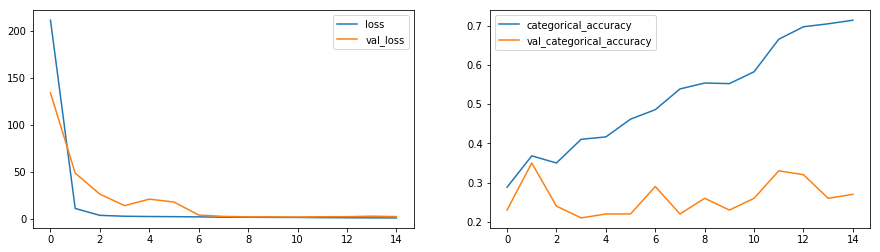

In [22]:
plot(history_CONV3D_v8)

### Model 9 - Conv3D
#### Model Code: CONV3D_v9
#### Model Description:
    # Filter size = [3, 3, 3]
    # Pool size = [3, 3, 3]
    # CONV 3D Layers = 2
    # Dense Layers = 1 (64)
    # Dropouts = Medium, add for FC
    # Regularizer = Yes, L2 regularizer
    # Trainable Parameters = ~861K

In [155]:
filtersize = [3, 3, 3]
image_shape = (128, 128)
input_shape = (framesPerVideo, image_shape[0], image_shape[1], 3)
pool_size = (3, 3, 3)

model = Sequential()
model.add(Conv3D(32, filtersize, input_shape=input_shape, activation='relu', kernel_initializer='he_uniform', 
                 padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=pool_size))
model.add(Dropout(0.50))

model.add(Conv3D(64, filtersize, activation='relu', kernel_initializer='he_uniform', 
                 padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=pool_size))
model.add(Dropout(0.50))

model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_initializer='he_uniform', activity_regularizer=l2(0.000001)))
model.add(BatchNormalization())
model.add(Dropout(0.30))

model.add(Dense(5, activation='softmax'))
optimiser = optimizers.Adam(lr=0.001)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_13 (Conv3D)           (None, 16, 128, 128, 32)  2624      
_________________________________________________________________
batch_normalization_10 (Batc (None, 16, 128, 128, 32)  128       
_________________________________________________________________
max_pooling3d_13 (MaxPooling (None, 5, 42, 42, 32)     0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 5, 42, 42, 32)     0         
_________________________________________________________________
conv3d_14 (Conv3D)           (None, 5, 42, 42, 64)     55360     
_________________________________________________________________
batch_normalization_11 (Batc (None, 5, 42, 42, 64)     256       
_________________________________________________________________
max_pooling3d_14 (MaxPooling (None, 1, 14, 14, 64)     0         
__________

In [156]:
history_CONV3D_v9 = model.fit_generator(retTrainGenerator(), steps_per_epoch=retStepsPerEpoch(), epochs=10, verbose=1, 
                    callbacks=retCallbacksList('CONV3D_v9'), validation_data=retValGenerator(), 
                    validation_steps=retValidationSteps(), class_weight=None, workers=1, initial_epoch=0)

Source path =  ../Project_data/val ; batch size = 20
Source path =  ../Project_data/train ; batch size = 20
Epoch 1/10


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  del sys.path[0]
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


32/34 [===========================>..] - ETA: 2s - loss: 1.6747 - categorical_accuracy: 0.3719

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:52: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


34/34 [==============================] - 45s 1s/step - loss: 1.6645 - categorical_accuracy: 0.3841 - val_loss: 1.2620 - val_categorical_accuracy: 0.4900

Epoch 00001: saving model to CONV3D_v9_model_init_2021-02-0717_59_19.205550/model-00001-1.66613-0.37707-1.26201-0.49000.h5
Epoch 2/10
34/34 [==============================] - 34s 994ms/step - loss: 1.1930 - categorical_accuracy: 0.5342 - val_loss: 1.0657 - val_categorical_accuracy: 0.6400

Epoch 00002: saving model to CONV3D_v9_model_init_2021-02-0717_59_19.205550/model-00002-1.19560-0.53092-1.06570-0.64000.h5
Epoch 3/10
34/34 [==============================] - 40s 1s/step - loss: 1.0181 - categorical_accuracy: 0.6093 - val_loss: 1.1726 - val_categorical_accuracy: 0.5200

Epoch 00003: saving model to CONV3D_v9_model_init_2021-02-0717_59_19.205550/model-00003-1.02716-0.60784-1.17265-0.52000.h5
Epoch 4/10
34/34 [==============================] - 39s 1s/step - loss: 0.9411 - categorical_accuracy: 0.6814 - val_loss: 1.0412 - val_categoric

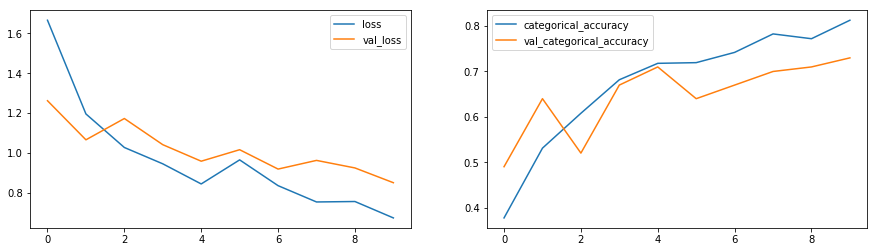

In [157]:
plot(history_CONV3D_v9)

### Model 10 - Conv3D
#### Model Code: CONV3D_v10
#### Model Description:
    # Filter size = [3, 3, 3]
    # Pool size = [2, 2, 2]
    # CONV 3D Layers = 4
    # Dense Layers = 2 
    # Dropouts = Low
    # Regularizer = No
    # Trainable Parameters = ~821K

In [158]:
filtersize = [3, 3, 3]
image_shape = (128, 128)
input_shape = (framesPerVideo, image_shape[0], image_shape[1], 3)
pool_size = (2, 2, 2)

model = Sequential()
model.add(Conv3D(16, filtersize, padding='same',
         input_shape=input_shape))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, filtersize, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, filtersize, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, filtersize, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))


model.add(Dense(5,activation='softmax'))

optimiser = optimizers.Adam(lr=0.0002)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_15 (Conv3D)           (None, 16, 128, 128, 16)  1312      
_________________________________________________________________
activation_7 (Activation)    (None, 16, 128, 128, 16)  0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 16, 128, 128, 16)  64        
_________________________________________________________________
max_pooling3d_15 (MaxPooling (None, 8, 64, 64, 16)     0         
_________________________________________________________________
conv3d_16 (Conv3D)           (None, 8, 64, 64, 32)     13856     
_________________________________________________________________
activation_8 (Activation)    (None, 8, 64, 64, 32)     0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 8, 64, 64, 32)     128       
__________

In [159]:
history_CONV3D_v10 = model.fit_generator(retTrainGenerator(), steps_per_epoch=retStepsPerEpoch(), epochs=10, verbose=1, 
                    callbacks=retCallbacksList('CONV3D_v10'), validation_data=retValGenerator(), 
                    validation_steps=retValidationSteps(), class_weight=None, workers=1, initial_epoch=0)

Source path =  ../Project_data/val ; batch size = 20
Source path =  ../Project_data/train ; batch size = 20
Epoch 1/10


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  del sys.path[0]
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


32/34 [===========================>..] - ETA: 2s - loss: 1.8639 - categorical_accuracy: 0.3375

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:52: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


34/34 [==============================] - 44s 1s/step - loss: 1.8449 - categorical_accuracy: 0.3458 - val_loss: 1.8253 - val_categorical_accuracy: 0.4100

Epoch 00001: saving model to CONV3D_v10_model_init_2021-02-0717_59_19.205550/model-00001-1.85992-0.33786-1.82527-0.41000.h5
Epoch 2/10
34/34 [==============================] - 29s 850ms/step - loss: 1.1271 - categorical_accuracy: 0.5504 - val_loss: 1.3025 - val_categorical_accuracy: 0.5200

Epoch 00002: saving model to CONV3D_v10_model_init_2021-02-0717_59_19.205550/model-00002-1.13768-0.54751-1.30252-0.52000.h5
Epoch 3/10
34/34 [==============================] - 38s 1s/step - loss: 1.0319 - categorical_accuracy: 0.5879 - val_loss: 1.1709 - val_categorical_accuracy: 0.6000

Epoch 00003: saving model to CONV3D_v10_model_init_2021-02-0717_59_19.205550/model-00003-1.01370-0.59427-1.17093-0.60000.h5
Epoch 4/10
34/34 [==============================] - 39s 1s/step - loss: 0.9592 - categorical_accuracy: 0.6004 - val_loss: 1.0570 - val_catego

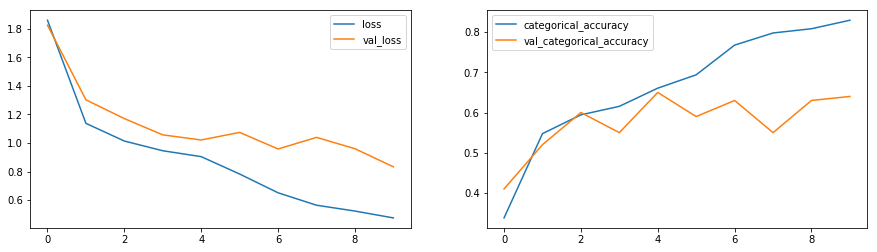

In [160]:
plot(history_CONV3D_v10)

### Model 11 - Conv3D
#### Model Code: CONV3D_v11
#### Model Description:
    # Filter size = [3, 3, 3]
    # Pool size = [2, 2, 2]
    # CONV 3D Layers = 4
    # Dense Layers = 2 (Increase the units)
    # Dropouts = Low
    # Regularizer = No
    # Trainable Parameters = ~1.3M
    # Increase the learning rate

In [32]:
filtersize = [3, 3, 3]
image_shape = (128, 128)
input_shape = (framesPerVideo, image_shape[0], image_shape[1], 3)
pool_size = (2, 2, 2)

model = Sequential()
model.add(Conv3D(16, filtersize, padding='same',
         input_shape=input_shape))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=pool_size))

model.add(Conv3D(32, filtersize, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=pool_size))

model.add(Conv3D(64, filtersize, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=pool_size))

model.add(Conv3D(128, filtersize, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=pool_size))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.35))

model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.35))


model.add(Dense(5,activation='softmax'))

optimiser = optimizers.Adam(lr=0.001)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_36 (Conv3D)           (None, 16, 128, 128, 16)  1312      
_________________________________________________________________
activation_36 (Activation)   (None, 16, 128, 128, 16)  0         
_________________________________________________________________
batch_normalization_52 (Batc (None, 16, 128, 128, 16)  64        
_________________________________________________________________
max_pooling3d_36 (MaxPooling (None, 8, 64, 64, 16)     0         
_________________________________________________________________
conv3d_37 (Conv3D)           (None, 8, 64, 64, 32)     13856     
_________________________________________________________________
activation_37 (Activation)   (None, 8, 64, 64, 32)     0         
_________________________________________________________________
batch_normalization_53 (Batc (None, 8, 64, 64, 32)     128       
__________

In [34]:
history_CONV3D_v11 = model.fit_generator(retTrainGenerator(), steps_per_epoch=retStepsPerEpoch(), epochs=10, verbose=1, 
                    callbacks=retCallbacksList('CONV3D_v11'), validation_data=retValGenerator(), 
                    validation_steps=retValidationSteps(), class_weight=None, workers=1, initial_epoch=0)

Source path =  ../Project_data/val ; batch size = 20
Source path =  ../Project_data/train ; batch size = 20
Epoch 17/30


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  del sys.path[0]
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


32/34 [===========================>..] - ETA: 2s - loss: 0.5730 - categorical_accuracy: 0.7875

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


34/34 [==============================] - 47s 1s/step - loss: 0.6650 - categorical_accuracy: 0.7778 - val_loss: 1.8310 - val_categorical_accuracy: 0.5000
Epoch 18/30
34/34 [==============================] - 44s 1s/step - loss: 0.5113 - categorical_accuracy: 0.8182 - val_loss: 1.1161 - val_categorical_accuracy: 0.6000
Epoch 19/30
34/34 [==============================] - 43s 1s/step - loss: 0.3936 - categorical_accuracy: 0.8580 - val_loss: 2.0138 - val_categorical_accuracy: 0.4400
Epoch 20/30
34/34 [==============================] - 44s 1s/step - loss: 0.3958 - categorical_accuracy: 0.8565 - val_loss: 1.2565 - val_categorical_accuracy: 0.6100
Epoch 21/30
34/34 [==============================] - 44s 1s/step - loss: 0.6283 - categorical_accuracy: 0.7689 - val_loss: 1.0476 - val_categorical_accuracy: 0.6500
Epoch 22/30
34/34 [==============================] - 44s 1s/step - loss: 0.5290 - categorical_accuracy: 0.7962 - val_loss: 5.6074 - val_categorical_accuracy: 0.2900
Epoch 23/30
34/34 [===

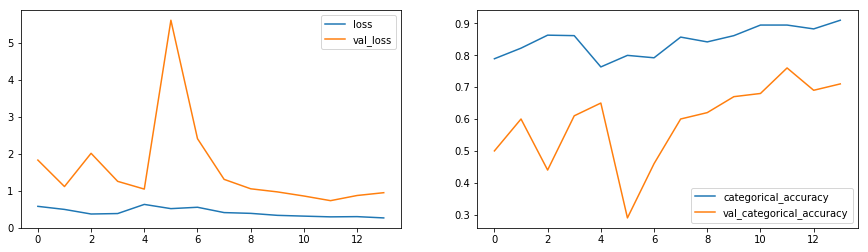

In [35]:
plot(history_CONV3D_v11)

### Model 12 - Conv3D
#### Model Code: CONV3D_v12
#### Model Description:
    # Filter size = [3, 3, 3]
    # Pool size = [2, 2, 2]
    # CONV 3D Layers = 4
    # Dense Layers = 2 (Increase the units)
    # Dropouts = Low
    # Regularizer = No
    # Trainable Parameters = ~2.4M
    # Increase the learning rate

In [53]:
filtersize = [3, 3, 3]
image_shape = (128, 128)
input_shape = (framesPerVideo, image_shape[0], image_shape[1], 3)
pool_size = (2, 2, 2)

model = Sequential()
model.add(Conv3D(16, filtersize, padding='same',
         input_shape=input_shape))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=pool_size))

model.add(Conv3D(32, filtersize, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=pool_size))

model.add(Conv3D(64, filtersize, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=pool_size))

model.add(Conv3D(128, filtersize, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=pool_size))

model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(256,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))


model.add(Dense(5,activation='softmax'))

optimiser = optimizers.Adam(lr=0.0002)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_48 (Conv3D)           (None, 16, 128, 128, 16)  1312      
_________________________________________________________________
activation_48 (Activation)   (None, 16, 128, 128, 16)  0         
_________________________________________________________________
batch_normalization_70 (Batc (None, 16, 128, 128, 16)  64        
_________________________________________________________________
max_pooling3d_48 (MaxPooling (None, 8, 64, 64, 16)     0         
_________________________________________________________________
conv3d_49 (Conv3D)           (None, 8, 64, 64, 32)     13856     
_________________________________________________________________
activation_49 (Activation)   (None, 8, 64, 64, 32)     0         
_________________________________________________________________
batch_normalization_71 (Batc (None, 8, 64, 64, 32)     128       
__________

In [54]:
history_CONV3D_v12 = model.fit_generator(retTrainGenerator(), steps_per_epoch=retStepsPerEpoch(), epochs=30, verbose=1, 
                    callbacks=retCallbacksList('CONV3D_v12'), validation_data=retValGenerator(), 
                    validation_steps=retValidationSteps(), class_weight=None, workers=1, initial_epoch=0)

Source path =  ../Project_data/val ; batch size = 20
Source path =  ../Project_data/train ; batch size = 20
Epoch 1/30


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  del sys.path[0]
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


32/34 [===========================>..] - ETA: 2s - loss: 2.0735 - categorical_accuracy: 0.3297

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


34/34 [==============================] - 50s 1s/step - loss: 2.0174 - categorical_accuracy: 0.3333 - val_loss: 1.7586 - val_categorical_accuracy: 0.4400
Epoch 2/30
34/34 [==============================] - 43s 1s/step - loss: 1.3690 - categorical_accuracy: 0.5327 - val_loss: 0.9805 - val_categorical_accuracy: 0.5600
Epoch 3/30
34/34 [==============================] - 44s 1s/step - loss: 1.1503 - categorical_accuracy: 0.5909 - val_loss: 0.8359 - val_categorical_accuracy: 0.6900
Epoch 4/30
34/34 [==============================] - 44s 1s/step - loss: 0.9780 - categorical_accuracy: 0.6556 - val_loss: 0.8191 - val_categorical_accuracy: 0.6900
Epoch 5/30
34/34 [==============================] - 44s 1s/step - loss: 0.9385 - categorical_accuracy: 0.6593 - val_loss: 0.7931 - val_categorical_accuracy: 0.6900
Epoch 6/30
34/34 [==============================] - 44s 1s/step - loss: 0.7603 - categorical_accuracy: 0.7241 - val_loss: 0.8102 - val_categorical_accuracy: 0.6900
Epoch 7/30
34/34 [=========

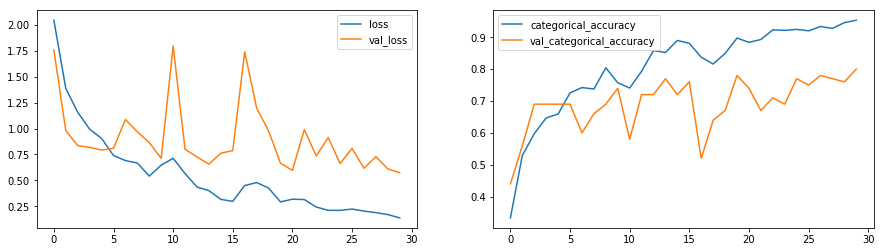

In [55]:
plot(history_CONV3D_v12)

In [ ]:
# ---------------------------End of Conv3D Models---------------------------

In [ ]:
# ---------------------------Start of Transfer Learning Models---------------------------

### Transfer Learning - Mobilenet (no trainable) with GRU (32) with 2 dense layers
#### Model Code = MobNetNT_GRU32_v1
#### Model Description:
    # Transfer Learning = Mobilenet (no trainable)
    # GRU Units = 32
    # Dense Layers = 2
    # Dropouts = Low
    # Regularizer = No
    # Trainable Parameters = ~399K

In [15]:
image_shape = (128, 128)
gru_cells = 32

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False, input_shape=(image_shape[0], image_shape[1], 3))
model = Sequential()
model.add(TimeDistributed(mobilenet_transfer,input_shape=(framesPerVideo, image_shape[0], image_shape[1], 3)))        
        
for layer in model.layers:
    layer.trainable = False
        
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Dropout(0.25)))
model.add(TimeDistributed(Flatten()))

model.add(GRU(gru_cells))
model.add(Dropout(0.25))

model.add(Dense(32))
model.add(Activation('relu'))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

optimiser = 'adam' #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

17227776/17225924 [==============================] - 0s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 16, 4, 4, 1024)    3228864   
_________________________________________________________________
time_distributed_2 (TimeDist (None, 16, 4, 4, 1024)    4096      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 16, 2, 2, 1024)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 16, 2, 2, 1024)    0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 16, 4096)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                396384    
_________________________________________________________________
dropout_2 (

In [16]:
history_MobNetNT_GRU32_v1 = model.fit_generator(retTrainGenerator(), steps_per_epoch=retStepsPerEpoch(), epochs=num_epochs, verbose=1, 
                    callbacks=retCallbacksList('MobNetNT_GRU32_v1'), validation_data=retValGenerator(), 
                    validation_steps=retValidationSteps(), class_weight=None, workers=1, initial_epoch=0)

Source path = Source path =  ../Project_data/train ; batch size = Epoch 1/10
20
 ../Project_data/val ; batch size = 20


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  del sys.path[0]
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


32/34 [===========================>..] - ETA: 7s - loss: 1.4517 - categorical_accuracy: 0.3703 

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


34/34 [==============================] - 122s 4s/step - loss: 1.4268 - categorical_accuracy: 0.3922 - val_loss: 1.2538 - val_categorical_accuracy: 0.4300
Epoch 2/10
34/34 [==============================] - 45s 1s/step - loss: 0.9336 - categorical_accuracy: 0.6777 - val_loss: 1.0132 - val_categorical_accuracy: 0.6500
Epoch 3/10
34/34 [==============================] - 45s 1s/step - loss: 0.6604 - categorical_accuracy: 0.7896 - val_loss: 1.0668 - val_categorical_accuracy: 0.5600
Epoch 4/10
34/34 [==============================] - 45s 1s/step - loss: 0.4579 - categorical_accuracy: 0.8661 - val_loss: 0.9033 - val_categorical_accuracy: 0.6300
Epoch 5/10
34/34 [==============================] - 45s 1s/step - loss: 0.3000 - categorical_accuracy: 0.9205 - val_loss: 0.8935 - val_categorical_accuracy: 0.6300
Epoch 6/10
34/34 [==============================] - 45s 1s/step - loss: 0.2232 - categorical_accuracy: 0.9426 - val_loss: 0.8498 - val_categorical_accuracy: 0.6800
Epoch 7/10
34/34 [========

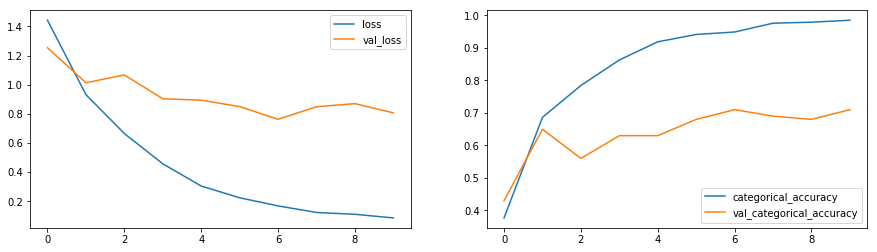

In [17]:
plot(history_MobNetNT_GRU32_v1)

###### We can see that the train data accuracy is increaseing but the validation is not so lets increase the dropouts

### Transfer Learning - Mobilenet (no trainable) with GRU (32) with 2 dense layers

#### Model Code = MobNetNT_GRU32_v2
#### Model Description:
    # Transfer Learning = Mobilenet (no trainable)
    # GRU Units = 32
    # Dense Layers = 2
    # Dropouts = Medium
    # Regularizer = No
    # Trainable Parameters = ~399K

In [161]:
image_shape = (128, 128)
gru_cells = 32

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False, input_shape=(image_shape[0], image_shape[1], 3))
model = Sequential()
model.add(TimeDistributed(mobilenet_transfer,input_shape=(framesPerVideo, image_shape[0], image_shape[1], 3)))        
        
for layer in model.layers:
    layer.trainable = False
        
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Dropout(0.50)))
model.add(TimeDistributed(Flatten()))

model.add(GRU(gru_cells))
model.add(Dropout(0.50))

model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dropout(0.50))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

optimiser = 'adam' #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_16 (TimeDis (None, 16, 4, 4, 1024)    3228864   
_________________________________________________________________
time_distributed_17 (TimeDis (None, 16, 4, 4, 1024)    4096      
_________________________________________________________________
time_distributed_18 (TimeDis (None, 16, 2, 2, 1024)    0         
_________________________________________________________________
time_distributed_19 (TimeDis (None, 16, 2, 2, 1024)    0         
_________________________________________________________________
time_distributed_20 (TimeDis (None, 16, 4096)          0         
_________________________________________________________________
gru_4 (GRU)                  (None, 32)                396384    
_________________________________________________________________
dropout_22 (Dropout)         (None, 32)                0         
__________

In [162]:
history_MobNetNT_GRU32_v2 = model.fit_generator(retTrainGenerator(), steps_per_epoch=retStepsPerEpoch(), epochs=num_epochs, verbose=1, 
                    callbacks=retCallbacksList('MobNetNT_GRU32_v2'), validation_data=retValGenerator(), 
                    validation_steps=retValidationSteps(), class_weight=None, workers=1, initial_epoch=0)

Source path =  ../Project_data/val ; batch size = 20
Source path =  ../Project_data/train Epoch 1/10
; batch size = 20


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  del sys.path[0]
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


32/34 [===========================>..] - ETA: 2s - loss: 1.8921 - categorical_accuracy: 0.2484

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:52: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


34/34 [==============================] - 45s 1s/step - loss: 1.8720 - categorical_accuracy: 0.2575 - val_loss: 1.5675 - val_categorical_accuracy: 0.2800

Epoch 00001: saving model to MobNetNT_GRU32_v2_model_init_2021-02-0717_59_19.205550/model-00001-1.89045-0.24736-1.56749-0.28000.h5
Epoch 2/10
34/34 [==============================] - 32s 938ms/step - loss: 1.6363 - categorical_accuracy: 0.2620 - val_loss: 1.5500 - val_categorical_accuracy: 0.3800

Epoch 00002: saving model to MobNetNT_GRU32_v2_model_init_2021-02-0717_59_19.205550/model-00002-1.61641-0.26848-1.55000-0.38000.h5
Epoch 3/10
34/34 [==============================] - 39s 1s/step - loss: 1.5562 - categorical_accuracy: 0.3260 - val_loss: 1.4969 - val_categorical_accuracy: 0.3600

Epoch 00003: saving model to MobNetNT_GRU32_v2_model_init_2021-02-0717_59_19.205550/model-00003-1.55706-0.32579-1.49688-0.36000.h5
Epoch 4/10
34/34 [==============================] - 38s 1s/step - loss: 1.4610 - categorical_accuracy: 0.3598 - val_loss

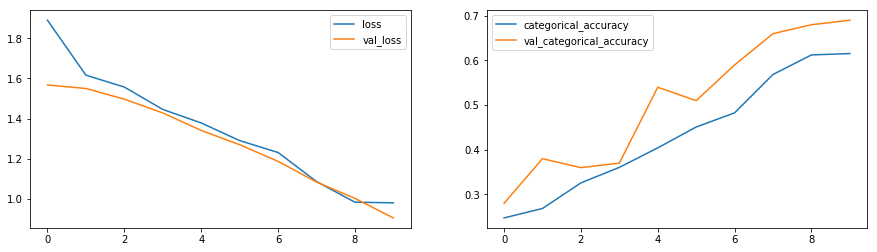

In [163]:
plot(history_MobNetNT_GRU32_v2)

###### We can see that the performance has dropped significants upon increasing the weights, 
###### so lets reduce the weights and increase the GRU units and dense layers

### Transfer Learning - Mobilenet (no trainable) with GRU (128) with 2 dense layers
#### Model Code = MobNetNT_GRU128_v1
#### Model Description:
    # Transfer Learning = Mobilenet (no trainable)
    # GRU Units = 128
    # Dense Layers = 3
    # Dropouts = Medium
    # Regularizer = No
    # Trainable Parameters = ~1.6M

In [24]:
image_shape = (128, 128)
gru_cells = 128

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False, input_shape=(image_shape[0], image_shape[1], 3))
model = Sequential()
model.add(TimeDistributed(mobilenet_transfer,input_shape=(framesPerVideo, image_shape[0], image_shape[1], 3)))        
        
for layer in model.layers:
    layer.trainable = False
        
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Dropout(0.50)))
model.add(TimeDistributed(Flatten()))

model.add(GRU(gru_cells))
model.add(Dropout(0.25))

model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.40))

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.40))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

optimiser = 'adam' #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_MobNetNT_GRU.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_16 (TimeDis (None, 16, 4, 4, 1024)    3228864   
_________________________________________________________________
time_distributed_17 (TimeDis (None, 16, 4, 4, 1024)    4096      
_________________________________________________________________
time_distributed_18 (TimeDis (None, 16, 2, 2, 1024)    0         
_________________________________________________________________
time_distributed_19 (TimeDis (None, 16, 2, 2, 1024)    0         
_________________________________________________________________
time_distributed_20 (TimeDis (None, 16, 4096)          0         
_________________________________________________________________
gru_4 (GRU)                  (None, 128)               1622400   
_________________________________________________________________
dropout_12 (Dropout)         (None, 128)               0         
__________

In [25]:
history_MobNetNT_GRU128_v1 = model.fit_generator(retTrainGenerator(), steps_per_epoch=retStepsPerEpoch(), epochs=num_epochs, verbose=1, 
                    callbacks=retCallbacksList('MobNetNT_GRU128_v1'), validation_data=retValGenerator(), 
                    validation_steps=retValidationSteps(), class_weight=None, workers=1, initial_epoch=0)

Source path =  ../Project_data/val ; batch size = 20
Source path =  ../Project_data/train ; batch size = 20
Epoch 1/10


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  del sys.path[0]
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


32/34 [===========================>..] - ETA: 2s - loss: 1.6596 - categorical_accuracy: 0.2828

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


34/34 [==============================] - 50s 1s/step - loss: 1.6432 - categorical_accuracy: 0.2929 - val_loss: 1.4833 - val_categorical_accuracy: 0.3100
Epoch 2/10
34/34 [==============================] - 43s 1s/step - loss: 1.3425 - categorical_accuracy: 0.4260 - val_loss: 1.3832 - val_categorical_accuracy: 0.4700
Epoch 3/10
34/34 [==============================] - 44s 1s/step - loss: 1.0790 - categorical_accuracy: 0.5798 - val_loss: 1.2787 - val_categorical_accuracy: 0.5200
Epoch 4/10
34/34 [==============================] - 43s 1s/step - loss: 0.9592 - categorical_accuracy: 0.6387 - val_loss: 1.0658 - val_categorical_accuracy: 0.5600
Epoch 5/10
34/34 [==============================] - 44s 1s/step - loss: 0.7650 - categorical_accuracy: 0.7101 - val_loss: 0.9120 - val_categorical_accuracy: 0.6200
Epoch 6/10
34/34 [==============================] - 44s 1s/step - loss: 0.6217 - categorical_accuracy: 0.7638 - val_loss: 0.7924 - val_categorical_accuracy: 0.6700
Epoch 7/10
34/34 [=========

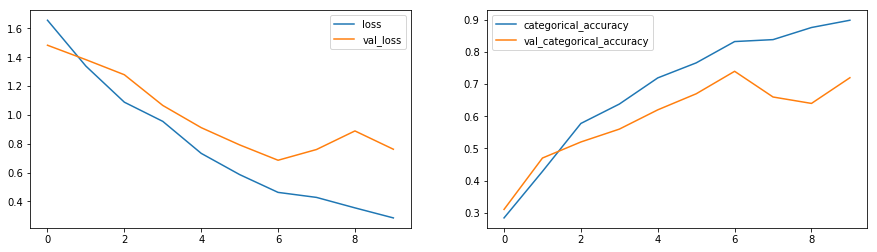

In [26]:
plot(history_MobNetNT_GRU128_v1)

###### Transfer Learning - Mobilenet (no trainable) with GRU (128) with 2 dense layers
###### With regularizer and increased dropouts

### Model Code = MobNetNT_GRU128_v2
#### Model Description:
    # Transfer Learning = Mobilenet (no trainable)
    # GRU Units = 128
    # Dense Layers = 3
    # Dropouts = Medium
    # Regularizer = Yes
    # Trainable Parameters = ~1.6M

In [164]:
image_shape = (128, 128)
gru_cells = 128

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False, input_shape=(image_shape[0], image_shape[1], 3))
model = Sequential()
model.add(TimeDistributed(mobilenet_transfer,input_shape=(framesPerVideo, image_shape[0], image_shape[1], 3)))        
        
for layer in model.layers:
    layer.trainable = False
        
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Dropout(0.50)))
model.add(TimeDistributed(Flatten()))

model.add(GRU(gru_cells))
model.add(Dropout(0.25))

model.add(Dense(128, activity_regularizer=l1(0.001)))
model.add(Activation('relu'))
model.add(Dropout(0.40))

model.add(Dense(64, activity_regularizer=l1(0.001)))
model.add(Activation('relu'))
model.add(Dropout(0.40))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

optimiser = 'adam' #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_21 (TimeDis (None, 16, 4, 4, 1024)    3228864   
_________________________________________________________________
time_distributed_22 (TimeDis (None, 16, 4, 4, 1024)    4096      
_________________________________________________________________
time_distributed_23 (TimeDis (None, 16, 2, 2, 1024)    0         
_________________________________________________________________
time_distributed_24 (TimeDis (None, 16, 2, 2, 1024)    0         
_________________________________________________________________
time_distributed_25 (TimeDis (None, 16, 4096)          0         
_________________________________________________________________
gru_5 (GRU)                  (None, 128)               1622400   
_________________________________________________________________
dropout_25 (Dropout)         (None, 128)               0         
__________

In [165]:
history_MobNetNT_GRU128_v2 = model.fit_generator(retTrainGenerator(), steps_per_epoch=retStepsPerEpoch(), epochs=10, verbose=1, 
                    callbacks=retCallbacksList('MobNetNT_GRU128_v2'), validation_data=retValGenerator(), 
                    validation_steps=retValidationSteps(), class_weight=None, workers=1, initial_epoch=0)

Source path =  ../Project_data/val ; batch size = 20
Source path =  Epoch 1/10
../Project_data/train ; batch size = 20


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  del sys.path[0]
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


32/34 [===========================>..] - ETA: 2s - loss: 3.8102 - categorical_accuracy: 0.2609

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:52: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


34/34 [==============================] - 44s 1s/step - loss: 3.7334 - categorical_accuracy: 0.2605 - val_loss: 2.7062 - val_categorical_accuracy: 0.3800

Epoch 00001: saving model to MobNetNT_GRU128_v2_model_init_2021-02-0717_59_19.205550/model-00001-3.77924-0.26697-2.70622-0.38000.h5
Epoch 2/10
34/34 [==============================] - 33s 963ms/step - loss: 2.8430 - categorical_accuracy: 0.3355 - val_loss: 2.2514 - val_categorical_accuracy: 0.3500

Epoch 00002: saving model to MobNetNT_GRU128_v2_model_init_2021-02-0717_59_19.205550/model-00002-2.86912-0.34389-2.25145-0.35000.h5
Epoch 3/10
34/34 [==============================] - 41s 1s/step - loss: 2.2907 - categorical_accuracy: 0.3429 - val_loss: 1.9710 - val_categorical_accuracy: 0.3900

Epoch 00003: saving model to MobNetNT_GRU128_v2_model_init_2021-02-0717_59_19.205550/model-00003-2.30047-0.35143-1.97104-0.39000.h5
Epoch 4/10
34/34 [==============================] - 41s 1s/step - loss: 2.0130 - categorical_accuracy: 0.3650 - val_l

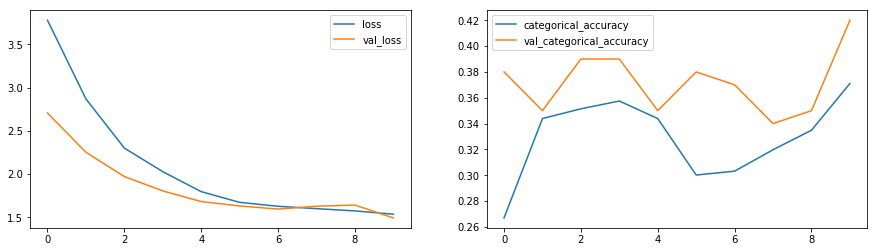

In [166]:
plot(history_MobNetNT_GRU128_v2)

###### Trying with l2 regularizer and reduced weights

### Model Code = MobNetNT_GRU128_v3
#### Model Description:
    # Transfer Learning = Mobilenet (no trainable)
    # GRU Units = 128
    # Dense Layers = 3
    # Dropouts = Medium
    # Regularizer = Yes (L2)
    # Trainable Parameters = ~1.6M

In [22]:
image_shape = (128, 128)
gru_cells = 128

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False, input_shape=(image_shape[0], image_shape[1], 3))
model = Sequential()
model.add(TimeDistributed(mobilenet_transfer,input_shape=(framesPerVideo, image_shape[0], image_shape[1], 3)))        
        
for layer in model.layers:
    layer.trainable = False
        
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Dropout(0.40)))
model.add(TimeDistributed(Flatten()))

model.add(GRU(gru_cells))
model.add(Dropout(0.25))

model.add(Dense(128, activity_regularizer=l2(0.001)))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(64, activity_regularizer=l2(0.001)))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

optimiser = 'adam' #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_11 (TimeDis (None, 16, 4, 4, 1024)    3228864   
_________________________________________________________________
time_distributed_12 (TimeDis (None, 16, 4, 4, 1024)    4096      
_________________________________________________________________
time_distributed_13 (TimeDis (None, 16, 2, 2, 1024)    0         
_________________________________________________________________
time_distributed_14 (TimeDis (None, 16, 2, 2, 1024)    0         
_________________________________________________________________
time_distributed_15 (TimeDis (None, 16, 4096)          0         
_________________________________________________________________
gru_3 (GRU)                  (None, 128)               1622400   
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
__________

In [23]:
history_MobNetNT_GRU128_v3 = model.fit_generator(retTrainGenerator(), steps_per_epoch=retStepsPerEpoch(), epochs=num_epochs, verbose=1, 
                    callbacks=retCallbacksList('MobNetNT_GRU128_v3'), validation_data=retValGenerator(), 
                    validation_steps=retValidationSteps(), class_weight=None, workers=1, initial_epoch=0)

Source path = Source path =  ../Project_data/train ; batch size = 20
 ../Project_data/val ; batch size = 20
Epoch 1/10


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  del sys.path[0]
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


32/34 [===========================>..] - ETA: 2s - loss: 2.6252 - categorical_accuracy: 0.2719

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


34/34 [==============================] - 49s 1s/step - loss: 2.5707 - categorical_accuracy: 0.2678 - val_loss: 1.6890 - val_categorical_accuracy: 0.2800
Epoch 2/10
34/34 [==============================] - 43s 1s/step - loss: 1.6027 - categorical_accuracy: 0.4216 - val_loss: 1.5018 - val_categorical_accuracy: 0.4300
Epoch 3/10
34/34 [==============================] - 44s 1s/step - loss: 1.3774 - categorical_accuracy: 0.5946 - val_loss: 1.3993 - val_categorical_accuracy: 0.4900
Epoch 4/10
34/34 [==============================] - 44s 1s/step - loss: 1.1583 - categorical_accuracy: 0.6792 - val_loss: 1.2783 - val_categorical_accuracy: 0.5300
Epoch 5/10
34/34 [==============================] - 43s 1s/step - loss: 1.0035 - categorical_accuracy: 0.7513 - val_loss: 1.1260 - val_categorical_accuracy: 0.6100
Epoch 6/10
34/34 [==============================] - 44s 1s/step - loss: 0.8353 - categorical_accuracy: 0.8263 - val_loss: 0.9709 - val_categorical_accuracy: 0.7300
Epoch 7/10
34/34 [=========

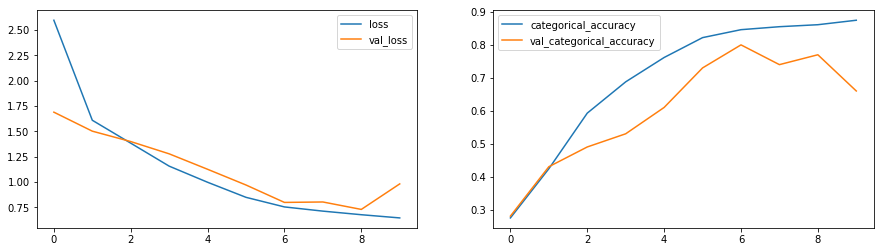

In [24]:
plot(history_MobNetNT_GRU128_v3)

With l2 regularizer performance is better but still there is still overfitting so lets simplify 
the model by removing one dense layer

### Model Code = MobNetNT_GRU64_v1
#### Model Description:
    # Transfer Learning = Mobilenet (no trainable)
    # GRU Units = 64
    # Dense Layers = 2
    # Dropouts = Medium
    # Regularizer = Yes (L2)
    # Trainable Parameters = 805K

In [27]:
image_shape = (128, 128)
gru_cells = 64

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False, input_shape=(image_shape[0], image_shape[1], 3))
model = Sequential()
model.add(TimeDistributed(mobilenet_transfer,input_shape=(framesPerVideo, image_shape[0], image_shape[1], 3)))        
        
for layer in model.layers:
    layer.trainable = False
        
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Dropout(0.40)))
model.add(TimeDistributed(Flatten()))

model.add(GRU(gru_cells))
model.add(Dropout(0.25))

model.add(Dense(64, activity_regularizer=l2(0.001)))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

optimiser = 'adam' #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_21 (TimeDis (None, 16, 4, 4, 1024)    3228864   
_________________________________________________________________
time_distributed_22 (TimeDis (None, 16, 4, 4, 1024)    4096      
_________________________________________________________________
time_distributed_23 (TimeDis (None, 16, 2, 2, 1024)    0         
_________________________________________________________________
time_distributed_24 (TimeDis (None, 16, 2, 2, 1024)    0         
_________________________________________________________________
time_distributed_25 (TimeDis (None, 16, 4096)          0         
_________________________________________________________________
gru_5 (GRU)                  (None, 64)                798912    
_________________________________________________________________
dropout_17 (Dropout)         (None, 64)                0         
__________

In [28]:
history_MobNetNT_GRU64_v1 = model.fit_generator(retTrainGenerator(), steps_per_epoch=retStepsPerEpoch(), epochs=num_epochs, verbose=1, 
                    callbacks=retCallbacksList('MobNetNT_GRU64_v1'), validation_data=retValGenerator(), 
                    validation_steps=retValidationSteps(), class_weight=None, workers=1, initial_epoch=0)

Source path =  ../Project_data/val ; batch size = 20
Source path =  ../Project_data/train ; batch size = 20Epoch 1/10



/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  del sys.path[0]
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


32/34 [===========================>..] - ETA: 2s - loss: 2.1011 - categorical_accuracy: 0.3891

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


34/34 [==============================] - 49s 1s/step - loss: 2.0715 - categorical_accuracy: 0.3893 - val_loss: 1.6248 - val_categorical_accuracy: 0.4300
Epoch 2/10
34/34 [==============================] - 43s 1s/step - loss: 1.4127 - categorical_accuracy: 0.6336 - val_loss: 1.3859 - val_categorical_accuracy: 0.5700
Epoch 3/10
34/34 [==============================] - 44s 1s/step - loss: 1.1239 - categorical_accuracy: 0.7859 - val_loss: 1.2464 - val_categorical_accuracy: 0.6300
Epoch 4/10
34/34 [==============================] - 43s 1s/step - loss: 0.9579 - categorical_accuracy: 0.8366 - val_loss: 1.1843 - val_categorical_accuracy: 0.5900
Epoch 5/10
34/34 [==============================] - 43s 1s/step - loss: 0.8473 - categorical_accuracy: 0.8727 - val_loss: 1.0929 - val_categorical_accuracy: 0.6700
Epoch 6/10
34/34 [==============================] - 43s 1s/step - loss: 0.7262 - categorical_accuracy: 0.9029 - val_loss: 1.0630 - val_categorical_accuracy: 0.6600
Epoch 7/10
34/34 [=========

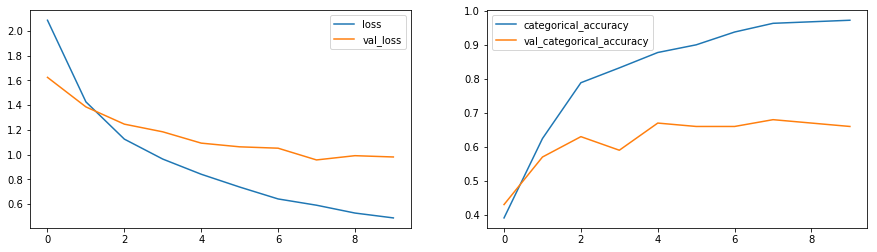

In [29]:
plot(history_MobNetNT_GRU64_v1)

Transfer Learning - Mobilenet (pre trained weights) with GRU (less dropouts),
We will reduce the GRU units as mobilenet will have high weights 

### Model Code = MobNetFT_GRU64_v1
#### Model Description:
    # Transfer Learning = Mobilenet (fully trainable)
    # GRU Units = 64
    # Dense Layers = 2
    # Dropouts = Medium
    # Regularizer = Yes (L2)
    # Trainable Parameters = ~4M

In [31]:
image_shape = (128, 128)
gru_cells = 64

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False, input_shape=(image_shape[0], image_shape[1], 3))
model = Sequential()
model.add(TimeDistributed(mobilenet_transfer,input_shape=(framesPerVideo, image_shape[0], image_shape[1], 3)))        
        
for layer in model.layers:
    layer.trainable = True
        
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Dropout(0.40)))
model.add(TimeDistributed(Flatten()))

model.add(GRU(gru_cells))
model.add(Dropout(0.40))

model.add(Dense(64, activity_regularizer=l2(0.001)))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

optimiser = 'adam' #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_31 (TimeDis (None, 16, 4, 4, 1024)    3228864   
_________________________________________________________________
time_distributed_32 (TimeDis (None, 16, 4, 4, 1024)    4096      
_________________________________________________________________
time_distributed_33 (TimeDis (None, 16, 2, 2, 1024)    0         
_________________________________________________________________
time_distributed_34 (TimeDis (None, 16, 2, 2, 1024)    0         
_________________________________________________________________
time_distributed_35 (TimeDis (None, 16, 4096)          0         
_________________________________________________________________
gru_7 (GRU)                  (None, 64)                798912    
_________________________________________________________________
dropout_23 (Dropout)         (None, 64)                0         
__________

In [32]:
history_MobNetFT_GRU64_v1 = model_MobNetNT_GRU.fit_generator(retTrainGenerator(), steps_per_epoch=retStepsPerEpoch(), epochs=num_epochs, verbose=1, 
                    callbacks=retCallbacksList('MobNetFT_GRU64_v1'), validation_data=retValGenerator(), 
                    validation_steps=retValidationSteps(), class_weight=None, workers=1, initial_epoch=0)

Source path =  ../Project_data/val Source path =  ../Project_data/train ; batch size = 20
Epoch 1/10
; batch size = 20


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  del sys.path[0]
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


23/34 [===================>..........] - ETA: 23s - loss: 2.2572 - categorical_accuracy: 0.3217

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


34/34 [==============================] - 66s 2s/step - loss: 2.0606 - categorical_accuracy: 0.3532 - val_loss: 1.4238 - val_categorical_accuracy: 0.6100
Epoch 2/10
34/34 [==============================] - 46s 1s/step - loss: 1.4165 - categorical_accuracy: 0.5776 - val_loss: 1.1215 - val_categorical_accuracy: 0.7300
Epoch 3/10
34/34 [==============================] - 46s 1s/step - loss: 1.1546 - categorical_accuracy: 0.7226 - val_loss: 0.9537 - val_categorical_accuracy: 0.7300
Epoch 4/10
34/34 [==============================] - 46s 1s/step - loss: 0.9674 - categorical_accuracy: 0.8241 - val_loss: 0.8638 - val_categorical_accuracy: 0.8300
Epoch 5/10
34/34 [==============================] - 46s 1s/step - loss: 0.8999 - categorical_accuracy: 0.8168 - val_loss: 0.9086 - val_categorical_accuracy: 0.7700
Epoch 6/10
34/34 [==============================] - 46s 1s/step - loss: 0.7985 - categorical_accuracy: 0.8661 - val_loss: 0.5927 - val_categorical_accuracy: 0.8800
Epoch 7/10
34/34 [=========

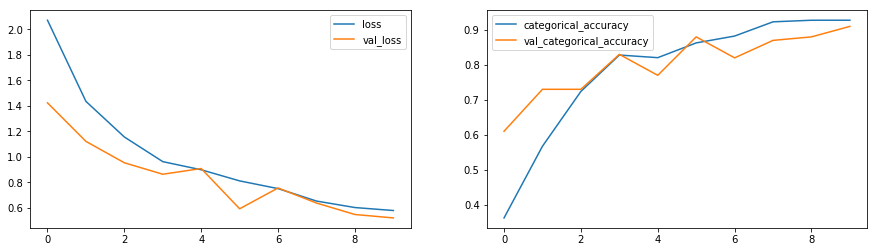

In [33]:
plot(history_MobNetFT_GRU64_v1)

Thus we have acheived a very good model, but the parameters involved are extremely high

As the parameters are huge lets try to reduce them,
First we will analyze the layers present in the mobilenet architecture,
Then we will start making the last few layers are trainable and other layers as non trainable.

##### Layers in mobilenet:

In [24]:
mobilenet_transfer.layers

### Model Code = MobNetPT_GRU64_v1
#### Model Description:
    # Transfer Learning = Mobilenet (partially trainable)
    # GRU Units = 64
    # Dense Layers = 2
    # Dropouts = Medium
    # Regularizer = Yes (L2)
    # Trainable Parameters = ~2.6M

In [15]:
image_shape = (128, 128)
gru_cells = 64

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False, input_shape=(image_shape[0], image_shape[1], 3))
model = Sequential()
model.add(TimeDistributed(mobilenet_transfer,input_shape=(framesPerVideo, image_shape[0], image_shape[1], 3)))        
        
for i, layer in enumerate(model.layers):
    if (i<70):
        layer.trainable = False
    else:
        layer.trainable = True
        
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Dropout(0.40)))
model.add(TimeDistributed(Flatten()))

model.add(GRU(gru_cells))
model.add(Dropout(0.40))

model.add(Dense(64, activity_regularizer=l2(0.001)))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

optimiser = 'adam' #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

17227776/17225924 [==============================] - 1s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 16, 4, 4, 1024)    3228864   
_________________________________________________________________
time_distributed_2 (TimeDist (None, 16, 4, 4, 1024)    4096      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 16, 2, 2, 1024)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 16, 2, 2, 1024)    0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 16, 4096)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                798912    
_________________________________________________________________
dropout_2 (

In [18]:
history_MobNetPT_GRU64_v1 = model.fit_generator(retTrainGenerator(), steps_per_epoch=retStepsPerEpoch(), epochs=20, verbose=1, 
                    callbacks=retCallbacksList('MobNetPT_GRU64_v1'), validation_data=retValGenerator(), 
                    validation_steps=retValidationSteps(), class_weight=None, workers=1, initial_epoch=10)

Source path = Source path =  ../Project_data/train ; batch size = 20
 ../Project_data/val ; batch size = Epoch 11/20
20


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  del sys.path[0]
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


32/34 [===========================>..] - ETA: 3s - loss: 0.6432 - categorical_accuracy: 0.9078

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


34/34 [==============================] - 66s 2s/step - loss: 0.6429 - categorical_accuracy: 0.9021 - val_loss: 0.5996 - val_categorical_accuracy: 0.8600
Epoch 12/20
34/34 [==============================] - 45s 1s/step - loss: 0.5894 - categorical_accuracy: 0.9168 - val_loss: 0.8467 - val_categorical_accuracy: 0.7000
Epoch 13/20
34/34 [==============================] - 43s 1s/step - loss: 0.5493 - categorical_accuracy: 0.9397 - val_loss: 0.5919 - val_categorical_accuracy: 0.7900
Epoch 14/20
34/34 [==============================] - 43s 1s/step - loss: 0.5677 - categorical_accuracy: 0.9088 - val_loss: 0.5728 - val_categorical_accuracy: 0.8300
Epoch 15/20
34/34 [==============================] - 44s 1s/step - loss: 0.5328 - categorical_accuracy: 0.9205 - val_loss: 0.6219 - val_categorical_accuracy: 0.8200
Epoch 16/20
34/34 [==============================] - 43s 1s/step - loss: 0.4686 - categorical_accuracy: 0.9507 - val_loss: 0.4905 - val_categorical_accuracy: 0.8900
Epoch 17/20
34/34 [===

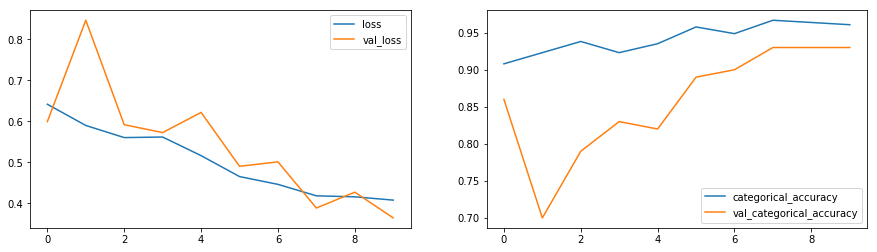

In [19]:
plot(history_MobNetPT_GRU64_v1)

Transfer Learning - Mobilenet (partially trainable weights) with GRU 

It is performing well lets try to reduce the parameters further lets increase the maxpooling, this is also a best model 
as it has less parameters and good accuracy levels

### Model Code = MobNetPT_GRU64_v2
#### Model Description:
    # Transfer Learning = Mobilenet (partially trainable v2)
    # GRU Units = 64
    # Dense Layers = 2
    # Dropouts = Medium
    # Regularizer = Yes (L2)
    # Trainable Parameters = ~2M

In [27]:
image_shape = (128, 128)
gru_cells = 64

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False, input_shape=(image_shape[0], image_shape[1], 3))
model = Sequential()
model.add(TimeDistributed(mobilenet_transfer,input_shape=(framesPerVideo, image_shape[0], image_shape[1], 3)))        
        
for i, layer in enumerate(model.layers):
    if (i<70):
        layer.trainable = False
    else:
        layer.trainable = True
        
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((3, 3))))
model.add(TimeDistributed(Dropout(0.45)))
model.add(TimeDistributed(Flatten()))

model.add(GRU(gru_cells))
model.add(Dropout(0.45))

model.add(Dense(64, activity_regularizer=l2(0.001)))
model.add(Activation('relu'))
model.add(Dropout(0.30))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

optimiser = 'adam' #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_16 (TimeDis (None, 16, 4, 4, 1024)    3228864   
_________________________________________________________________
time_distributed_17 (TimeDis (None, 16, 4, 4, 1024)    4096      
_________________________________________________________________
time_distributed_18 (TimeDis (None, 16, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_19 (TimeDis (None, 16, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_20 (TimeDis (None, 16, 1024)          0         
_________________________________________________________________
gru_4 (GRU)                  (None, 64)                209088    
_________________________________________________________________
dropout_12 (Dropout)         (None, 64)                0         
__________

In [31]:
history_MobNetPT_GRU64_v2 = model.fit_generator(retTrainGenerator(), steps_per_epoch=retStepsPerEpoch(), epochs=30, verbose=1, 
                    callbacks=retCallbacksList('MobNetPT_GRU64_v2'), validation_data=retValGenerator(), 
                    validation_steps=retValidationSteps(), class_weight=None, workers=1, initial_epoch=17)

Source path =  ../Project_data/val ; batch size = 20
Source path =  ../Project_data/train ; batch size =Epoch 18/30
 20


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  del sys.path[0]
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


32/34 [===========================>..] - ETA: 2s - loss: 0.5047 - categorical_accuracy: 0.9234

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


34/34 [==============================] - 46s 1s/step - loss: 0.4964 - categorical_accuracy: 0.9235 - val_loss: 0.6555 - val_categorical_accuracy: 0.7900
Epoch 19/30
34/34 [==============================] - 42s 1s/step - loss: 0.4795 - categorical_accuracy: 0.9419 - val_loss: 0.5476 - val_categorical_accuracy: 0.8600
Epoch 20/30
34/34 [==============================] - 42s 1s/step - loss: 0.4629 - categorical_accuracy: 0.9330 - val_loss: 0.5145 - val_categorical_accuracy: 0.8400
Epoch 21/30
34/34 [==============================] - 42s 1s/step - loss: 0.4472 - categorical_accuracy: 0.9507 - val_loss: 0.4860 - val_categorical_accuracy: 0.8700
Epoch 22/30
34/34 [==============================] - 43s 1s/step - loss: 0.4134 - categorical_accuracy: 0.9544 - val_loss: 0.6061 - val_categorical_accuracy: 0.8100
Epoch 23/30
34/34 [==============================] - 43s 1s/step - loss: 0.3640 - categorical_accuracy: 0.9794 - val_loss: 0.4010 - val_categorical_accuracy: 0.9200
Epoch 24/30
34/34 [===

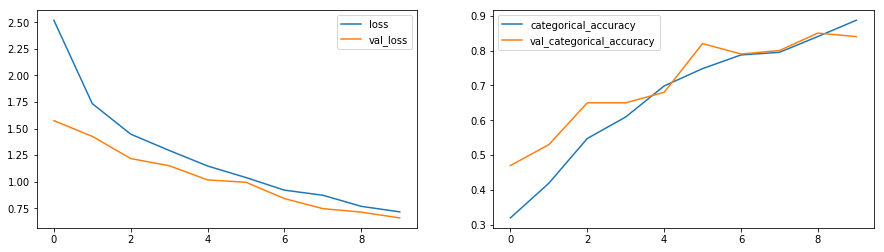

In [29]:
plot(history_MobNetPT_GRU64_v2)

Lets further reduce the parameters - This model is the best as it has further reduced parameters and high accuracy (90%)

### Model Code = MobNetPT_GRU64_v3
#### Model Description:
    # Transfer Learning = Mobilenet (partially trainable v3)
    # GRU Units = 64
    # Dense Layers = 2
    # Dropouts = Medium
    # Regularizer = Yes (L2)
    # Trainable Parameters = ~1.8M

In [39]:
image_shape = (128, 128)
gru_cells = 64

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False, input_shape=(image_shape[0], image_shape[1], 3))
model = Sequential()
model.add(TimeDistributed(mobilenet_transfer,input_shape=(framesPerVideo, image_shape[0], image_shape[1], 3)))        
        
for i, layer in enumerate(model.layers):
    if (i<78):
        layer.trainable = False
    else:
        layer.trainable = True
        
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((3, 3))))
model.add(TimeDistributed(Dropout(0.45)))
model.add(TimeDistributed(Flatten()))

model.add(GRU(gru_cells))
model.add(Dropout(0.45))

model.add(Dense(64, activity_regularizer=l2(0.001)))
model.add(Activation('relu'))
model.add(Dropout(0.30))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

optimiser = 'adam' #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_41 (TimeDis (None, 16, 4, 4, 1024)    3228864   
_________________________________________________________________
time_distributed_42 (TimeDis (None, 16, 4, 4, 1024)    4096      
_________________________________________________________________
time_distributed_43 (TimeDis (None, 16, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_44 (TimeDis (None, 16, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_45 (TimeDis (None, 16, 1024)          0         
_________________________________________________________________
gru_9 (GRU)                  (None, 64)                209088    
_________________________________________________________________
dropout_27 (Dropout)         (None, 64)                0         
__________

In [42]:
history_MobNetPT_GRU64_v3 = model_MobNetNT_GRU.fit_generator(retTrainGenerator(), steps_per_epoch=retStepsPerEpoch(), epochs=20, verbose=1, 
                    callbacks=retCallbacksList('MobNetPT_GRU64_v3'), validation_data=retValGenerator(), 
                    validation_steps=retValidationSteps(), class_weight=None, workers=1, initial_epoch=11)

Source path =  ../Project_data/val ; batch size = 20
Source path =  ../Project_data/train ; batch size = 20
Epoch 12/20


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  del sys.path[0]
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


32/34 [===========================>..] - ETA: 2s - loss: 0.7435 - categorical_accuracy: 0.8656

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


34/34 [==============================] - 44s 1s/step - loss: 0.7691 - categorical_accuracy: 0.8469 - val_loss: 0.6339 - val_categorical_accuracy: 0.8500
Epoch 13/20
34/34 [==============================] - 41s 1s/step - loss: 0.7506 - categorical_accuracy: 0.8514 - val_loss: 0.7370 - val_categorical_accuracy: 0.8000
Epoch 14/20
34/34 [==============================] - 41s 1s/step - loss: 0.6686 - categorical_accuracy: 0.8882 - val_loss: 0.6944 - val_categorical_accuracy: 0.8400
Epoch 15/20
34/34 [==============================] - 40s 1s/step - loss: 0.6128 - categorical_accuracy: 0.9080 - val_loss: 0.5961 - val_categorical_accuracy: 0.8500
Epoch 16/20
34/34 [==============================] - 40s 1s/step - loss: 0.6202 - categorical_accuracy: 0.8904 - val_loss: 0.6399 - val_categorical_accuracy: 0.8300
Epoch 17/20
34/34 [==============================] - 40s 1s/step - loss: 0.5139 - categorical_accuracy: 0.9485 - val_loss: 0.6184 - val_categorical_accuracy: 0.8300
Epoch 18/20
34/34 [===

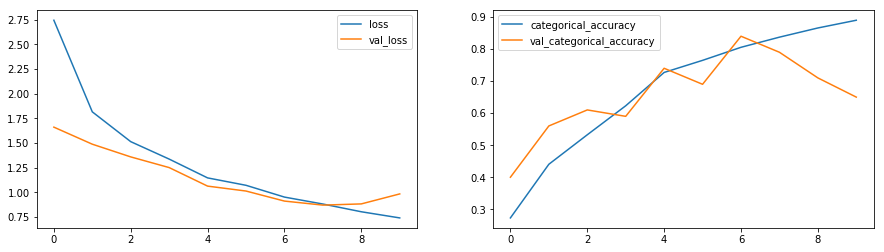

In [41]:
plot(history_MobNetPT_GRU64_v3)

Reduce parameters further

### Model Code = MobNetPT_GRU64_v4
#### Model Description:
    # Transfer Learning = Mobilenet (partially trainable v4)
    # GRU Units = 64
    # Dense Layers = 2
    # Dropouts = Medium
    # Regularizer = Yes (L2)
    # Trainable Parameters = ~1.2M

In [69]:
image_shape = (128, 128)
gru_cells = 64

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False, input_shape=(image_shape[0], image_shape[1], 3))
model = Sequential()
model.add(TimeDistributed(mobilenet_transfer,input_shape=(framesPerVideo, image_shape[0], image_shape[1], 3)))        
        
for i, layer in enumerate(mobilenet_transfer.layers):
    if (i<84):
        layer.trainable = False
    else:
        layer.trainable = True
        
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((3, 3))))
model.add(TimeDistributed(Dropout(0.45)))
model.add(TimeDistributed(Flatten()))

model.add(GRU(gru_cells))
model.add(Dropout(0.45))

model.add(Dense(64, activity_regularizer=l2(0.001)))
model.add(Activation('relu'))
model.add(Dropout(0.30))

model.add(Dense(5))
model.add(Activation('softmax'))

optimiser = 'adam' #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_11 (TimeDis (None, 16, 4, 4, 1024)    3228864   
_________________________________________________________________
time_distributed_12 (TimeDis (None, 16, 4, 4, 1024)    4096      
_________________________________________________________________
time_distributed_13 (TimeDis (None, 16, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_14 (TimeDis (None, 16, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_15 (TimeDis (None, 16, 1024)          0         
_________________________________________________________________
gru_3 (GRU)                  (None, 64)                209088    
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
__________

In [70]:
history_MobNetPT_GRU64_v4 = model.fit_generator(retTrainGenerator(), steps_per_epoch=retStepsPerEpoch(), epochs=50, verbose=1, 
                    callbacks=retCallbacksList('MobNetPT_GRU64_v4'), validation_data=retValGenerator(), 
                    validation_steps=retValidationSteps(), class_weight=None, workers=1, initial_epoch=0)

Source path =  ../Project_data/val ; batch size = 20
Source path =  ../Project_data/train ; batch size = 20
Epoch 1/50


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  del sys.path[0]
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


32/34 [===========================>..] - ETA: 2s - loss: 2.6076 - categorical_accuracy: 0.3031

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:52: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


34/34 [==============================] - 44s 1s/step - loss: 2.5631 - categorical_accuracy: 0.3024 - val_loss: 1.7160 - val_categorical_accuracy: 0.3800

Epoch 00001: saving model to MobNetPT_GRU64_v4_model_init_2021-02-0717_13_39.881291/model-00001-2.58570-0.30166-1.71603-0.38000.h5
Epoch 2/50
34/34 [==============================] - 34s 996ms/step - loss: 1.8468 - categorical_accuracy: 0.3841 - val_loss: 1.5468 - val_categorical_accuracy: 0.4300

Epoch 00002: saving model to MobNetPT_GRU64_v4_model_init_2021-02-0717_13_39.881291/model-00002-1.84357-0.39367-1.54677-0.43000.h5
Epoch 3/50
34/34 [==============================] - 39s 1s/step - loss: 1.5632 - categorical_accuracy: 0.4967 - val_loss: 1.4108 - val_categorical_accuracy: 0.5900

Epoch 00003: saving model to MobNetPT_GRU64_v4_model_init_2021-02-0717_13_39.881291/model-00003-1.55956-0.50075-1.41076-0.59000.h5
Epoch 4/50
34/34 [==============================] - 37s 1s/step - loss: 1.3616 - categorical_accuracy: 0.5990 - val_loss

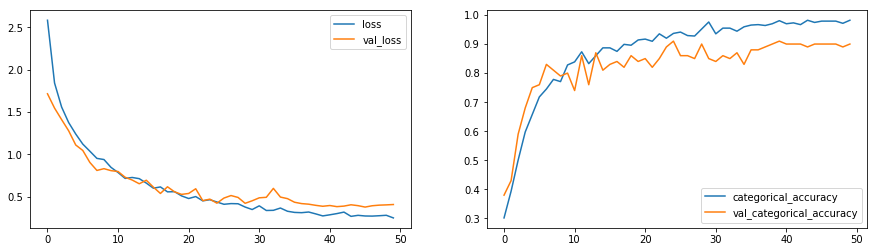

In [72]:
plot(history_MobNetPT_GRU64_v4)

In [ ]:
# ---------------------------End of Transfer Learning Models---------------------------

In [ ]:
# ---------------------------Start of Evaluating Model---------------------------

In [167]:
# Choose the best model
best_model = tf.keras.models.load_model('MobNetPT_GRU64_v4_model_init_2021-02-0717_13_39.881291/model-00040-0.27173-0.98039-0.38590-0.91000.h5')
best_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_11 (TimeDis (None, 16, 4, 4, 1024)    3228864   
_________________________________________________________________
time_distributed_12 (TimeDis (None, 16, 4, 4, 1024)    4096      
_________________________________________________________________
time_distributed_13 (TimeDis (None, 16, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_14 (TimeDis (None, 16, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_15 (TimeDis (None, 16, 1024)          0         
_________________________________________________________________
gru_3 (GRU)                  (None, 64)                209088    
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
__________

In [168]:
# Let's use a data unit from the validation set
batch_data, batch_labels = next(generator(val_path, val_doc, batch_size))

Source path =  ../Project_data/val ; batch size = 20


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  del sys.path[0]
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


In [169]:
# Let's prepare the actual output batch label
check = "["
for i in batch_labels:
    for j, val in enumerate(i):
        if (val == 1):
            check = check + " " + str(j)
check = check + "]"

In [170]:
print("Predicted data - ", np.argmax(best_model.predict(batch_data[:,:,:,:,:]),axis=1))
print("Actual data -   ", check)

Predicted data -  [3 2 2 1 2 2 3 4 2 0 1 1 2 4 0 0 4 1 1 4]
Actual data -    [ 3 2 2 1 2 2 3 4 2 0 0 1 2 4 0 0 4 1 1 4]


- We can see that there is only one miss prediction in the evaluation.

In [ ]:
# ---------------------------End of Evaluating Model---------------------------